In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
# Generate data paths with labels
data_dir = 'lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
# df = df.sample(frac=0.1) # Using only 10% of original data


In [32]:
df

filepaths  \
12636  lung_colon_image_set\lung_image_sets\lung_aca\...   
16755  lung_colon_image_set\lung_image_sets\lung_n\lu...   
4737   lung_colon_image_set\colon_image_sets\colon_ac...   
1161   lung_colon_image_set\colon_image_sets\colon_ac...   
5120   lung_colon_image_set\colon_image_sets\colon_n\...   
...                                                  ...   
1000   lung_colon_image_set\colon_image_sets\colon_ac...   
21485  lung_colon_image_set\lung_image_sets\lung_scc\...   
23798  lung_colon_image_set\lung_image_sets\lung_scc\...   
23499  lung_colon_image_set\lung_image_sets\lung_scc\...   
21686  lung_colon_image_set\lung_image_sets\lung_scc\...   

                             labels  
12636           Lung Adenocarcinoma  
16755            Lung Benign Tissue  
4737           Colon Adenocarcinoma  
1161           Colon Adenocarcinoma  
5120            Colon Benign Tissue  
...                             ...  
1000           Colon Adenocarcinoma  
21485  Lung Squamous Cell Carcinoma  
23798  Lung Squamous Cell Carcinoma  
23499  Lung Squamous Cell Carcinoma  
21686  Lung Squamous Cell Carcinoma  

[2500 rows x 2 columns]

In [33]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [34]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 2000 validated image filenames belonging to 5 classes.
Found 250 validated image filenames belonging to 5 classes.
Found 250 validated image filenames belonging to 5 classes.


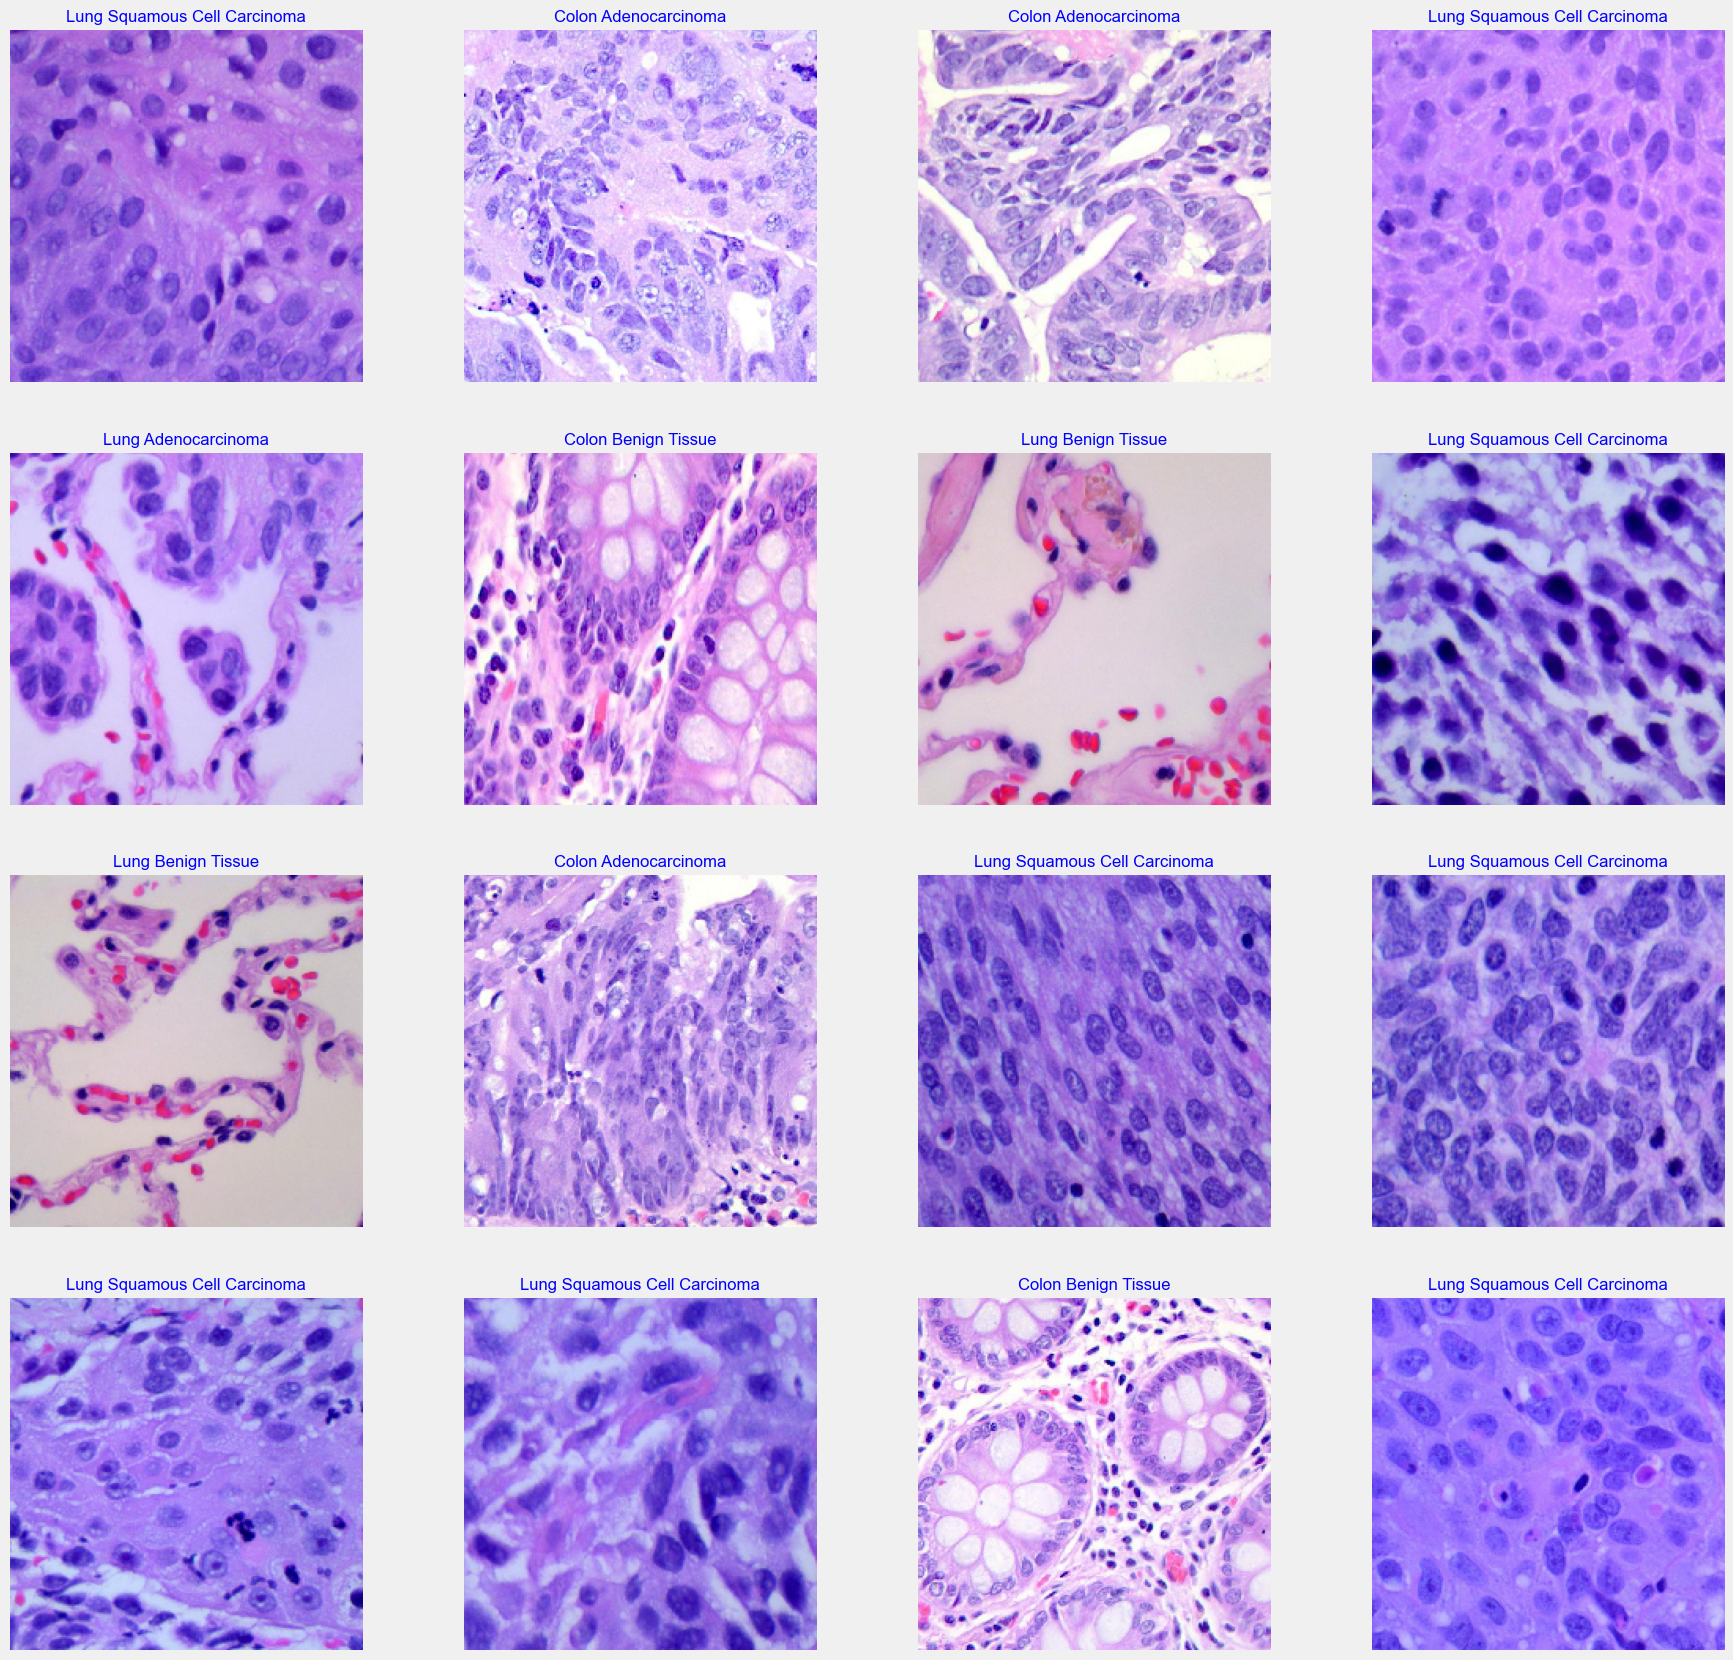

In [35]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [36]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [37]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 436s 14s/step - accuracy: 0.2478 - loss: 97.7565 - val_accuracy: 0.4560 - val_loss: 1.0194
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 430s 13s/step - accuracy: 0.4266 - loss: 1.0709 - val_accuracy: 0.4720 - val_loss: 0.9778
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 430s 13s/step - accuracy: 0.4836 - loss: 0.9645 - val_accuracy: 0.5120 - val_loss: 0.9646
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 422s 13s/step - accuracy: 0.5067 - loss: 0.9463 - val_accuracy: 0.5360 - val_loss: 1.1656
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 423s 13s/step - accuracy: 0.5428 - loss: 0.9396 - val_accuracy: 0.7760 - val_loss: 0.6576
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 420s 13s/step - accuracy: 0.7248 - loss: 0.6213 - val_accuracy: 0.7880 - val_loss: 0.5198
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 423s 13s/step - accuracy: 0.8382 - loss: 0.4152 - val_accuracy: 0.8640 - val_loss: 0.4147
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 432s 13s/step - accuracy: 0.8482 - loss: 0.3706 - val_accuracy: 0

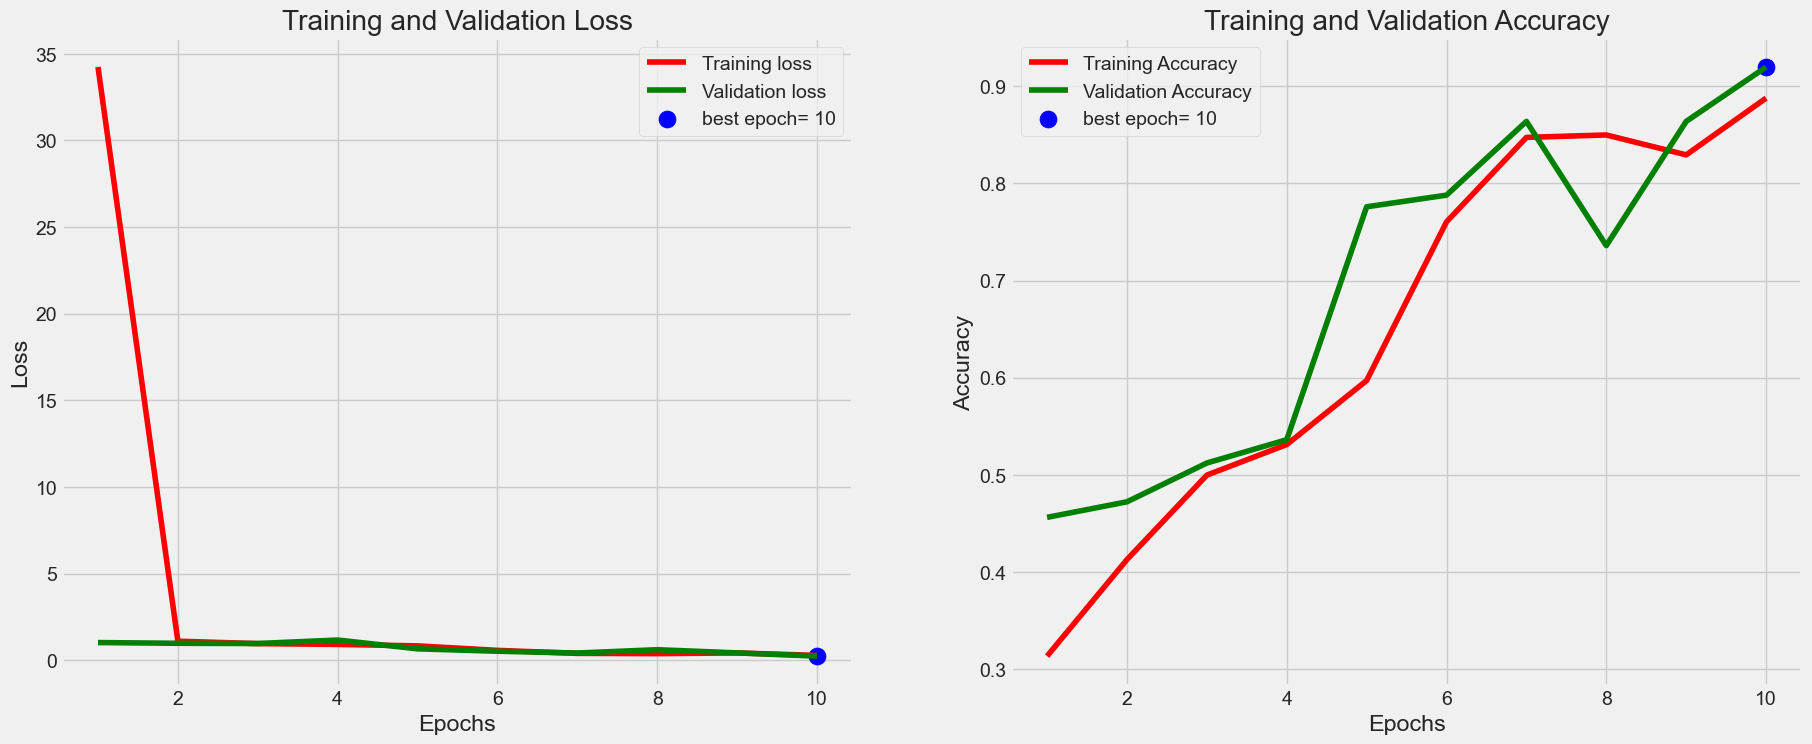

In [38]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [41]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9217 - loss: 0.2171
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8959 - loss: 0.2329
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9295 - loss: 0.2473
Train Loss:  0.23295052349567413
Train Accuracy:  0.918749988079071
--------------------
Valid Loss:  0.24929028749465942
Valid Accuracy:  0.8920000195503235
--------------------
Test Loss:  0.2368984818458557
Test Accuracy:  0.9200000166893005


In [42]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


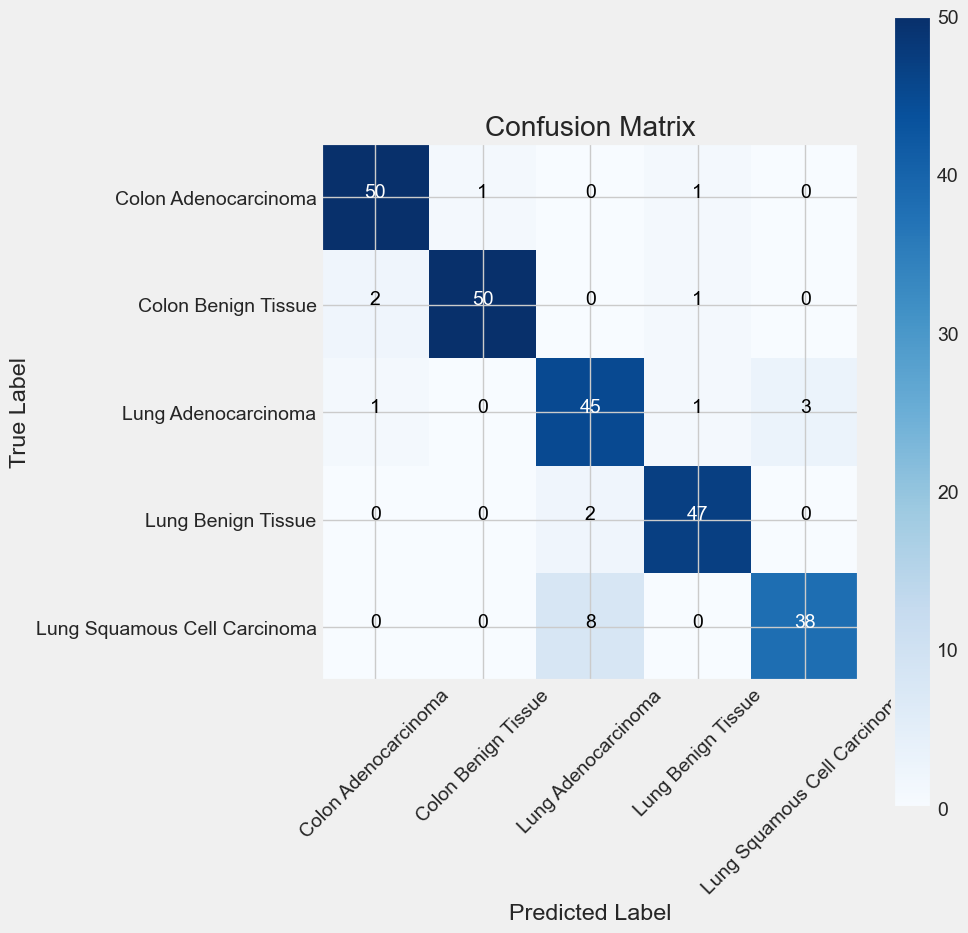

In [43]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [44]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.94      0.96      0.95        52
         Colon Benign Tissue       0.98      0.94      0.96        53
         Lung Adenocarcinoma       0.82      0.90      0.86        50
          Lung Benign Tissue       0.94      0.96      0.95        49
Lung Squamous Cell Carcinoma       0.93      0.83      0.87        46

                    accuracy                           0.92       250
                   macro avg       0.92      0.92      0.92       250
                weighted avg       0.92      0.92      0.92       250



In [39]:
#Save the model
model.save('Model.h5')

In [45]:
loaded_model = tf.keras.models.load_model('Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [46]:
image_path = 'lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Lung Adenocarcinoma
